In [61]:

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.17.1
The following GPU devices are available: 


In [118]:
def get_label_of_class_id(filepath, target_id, value_name):
    try:
        with open(filepath, "r") as file:
            lines = file.readlines()
    except FileNotFoundError:
        print(f"Error: File not found: {filepath}")
        return None
    except IOError:
        print(f"Error: Could not read the file: {filepath}")
        return None
    found_target = False
    for i in range(len(lines)):
        line = lines[i].strip()
        if line.startswith("id:") and int(line.split(":")[1].strip()) == target_id:
            found_target = True
            cls_name = (lines[i+1].strip(""))
            cls_name = cls_name.split(":")[1].strip().replace('"', '')
            return cls_name

    if not found_target:
        return None

#labels_path = tf.keras.utils.get_file(fname='labels.txt',origin='https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt')


In [120]:
tst=get_label_of_class_id(labels_path,0 , "display_name")
print(tst)

None


In [89]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    print(scores[i])
    print(class_names[i])
    if scores[i].numpy().any() >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i][:4])
      #display_str = "{}: {}%".format(class_names[i].decode("ascii"),
      #                               int(100 * scores[i]))
      display_str = get_label_of_class_id(labels_path, class_names[i], "display_name")
      #color = colors[hash(class_names[i]) % len(colors)]
      color = colors[hash(int(class_names[i].numpy())) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [64]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.expand_dims(img, axis=0)
  return img

In [66]:
# Apply image detector on a single image.
detector = hub.load("https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/TensorFlow2/ssd-mobilenet-v2/1")
labels_path = tf.keras.utils.get_file(fname='labels.txt',origin='https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt')

In [74]:
image_tensor = load_img("/content/original.jpg")
image_tensor = load_img("/content/2.png")

In [123]:
image_tensor = load_img("/content/original.jpg")
detector_output = detector(image_tensor)
class_ids = detector_output["detection_classes"]

tf.Tensor(0.8226454, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)


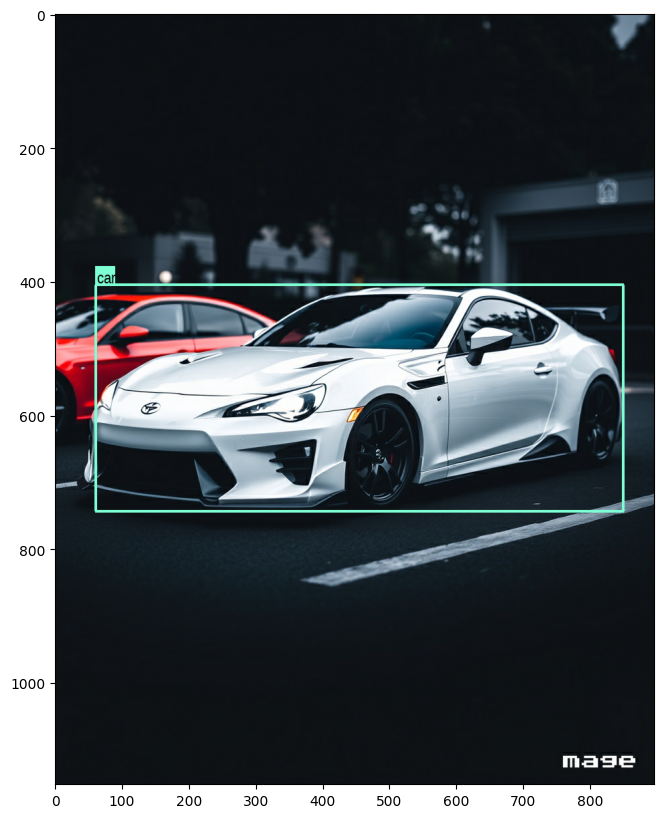

In [124]:
image_with_boxes = draw_boxes(
    image_tensor[0].numpy(), detector_output["detection_boxes"][0],
    class_ids[0], detector_output["detection_scores"][0],max_boxes=1, min_score=0.1)

plt.figure(figsize=(10,10))
plt.imshow(image_with_boxes)
plt.show()